<a href="https://colab.research.google.com/github/aymenchibouti/newversion/blob/master/rendom_forest_res_visulization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install shap
!pip install lime
!pip install xgboost
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import shap
import lime
import lime.lime_tabular
import xgboost as xgb
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight


=== Correlation of each feature with 'dropout' (descending) ===
dropout              1.000000
day_30_wiki         -0.015610
day_29_wiki         -0.023526
day_17_wiki         -0.025522
day_28_wiki         -0.025957
day_27_wiki         -0.028977
day_22_wiki         -0.029731
day_25_wiki         -0.030969
day_24_wiki         -0.036428
day_5_wiki          -0.037634
day_23_wiki         -0.038701
day_26_wiki         -0.039242
day_11_wiki         -0.040103
day_14_wiki         -0.042076
day_20_wiki         -0.042488
day_19_wiki         -0.044498
day_12_wiki         -0.046629
day_21_wiki         -0.046806
day_6_wiki          -0.046846
day_10_wiki         -0.048159
day_13_wiki         -0.049866
day_20_discussion   -0.050692
day_30_discussion   -0.050937
day_27_discussion   -0.051698
day_16_wiki         -0.052155
day_4_wiki          -0.053201
day_9_wiki          -0.053583
day_4_access        -0.055796
day_18_wiki         -0.060217
day_7_wiki          -0.060406
day_16_discussion   -0.062119
day_1

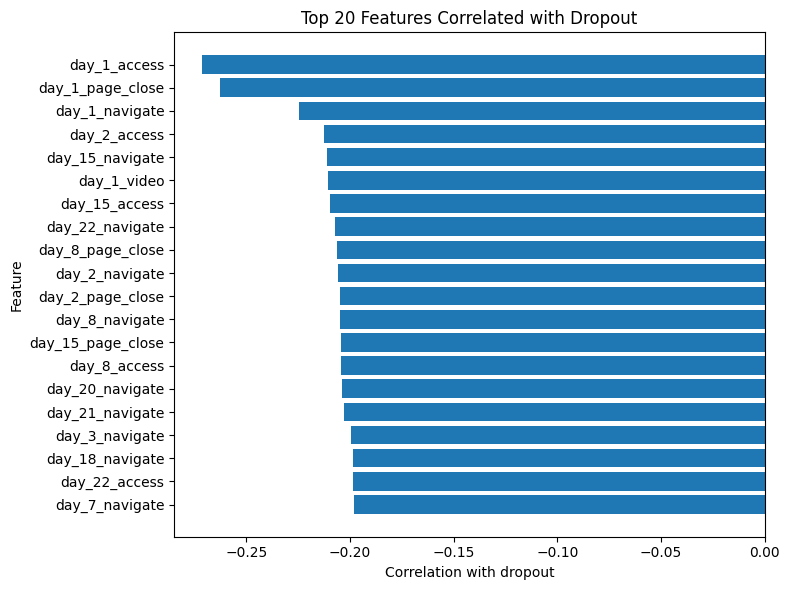

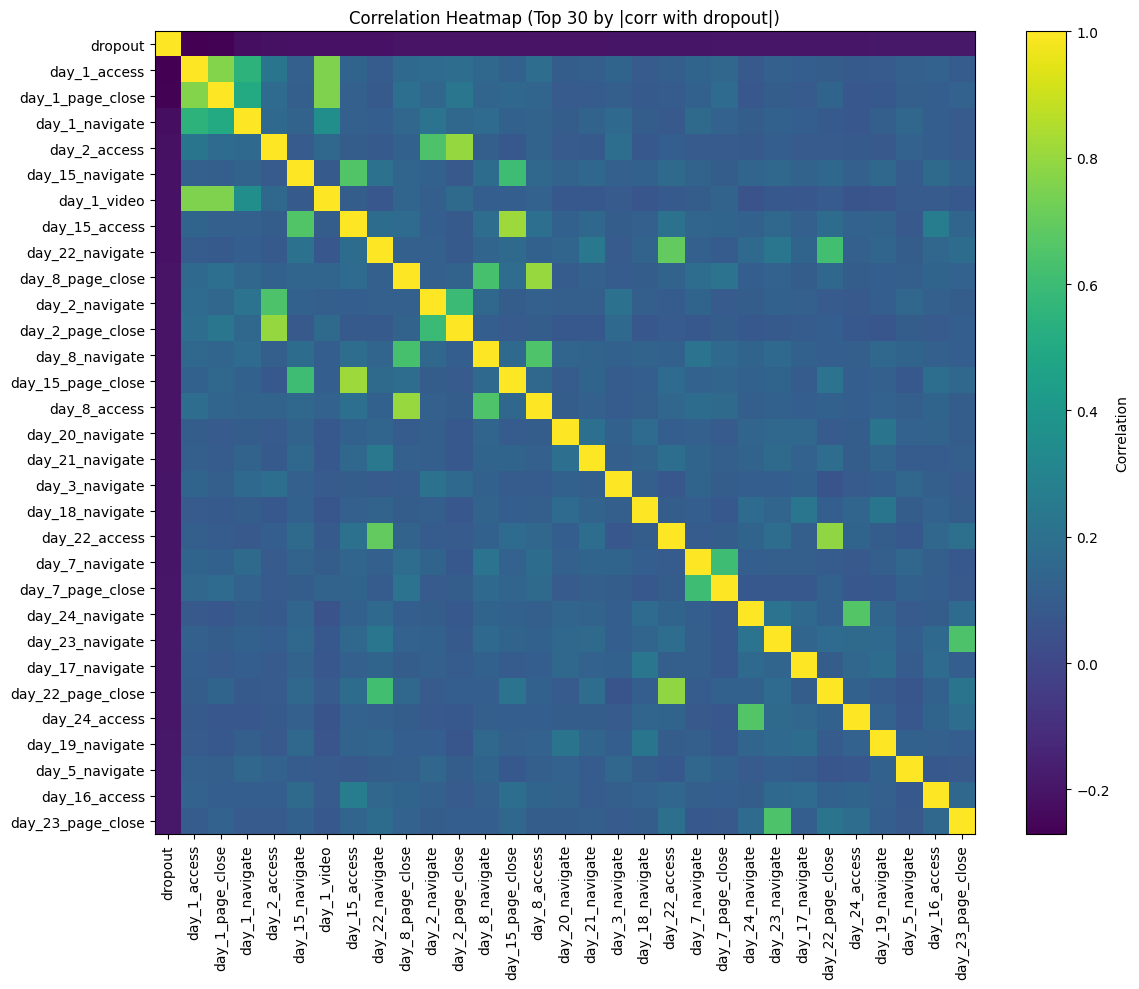

Fitting 3 folds for each of 100 candidates, totalling 300 fits

Best RandomForest Params: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': False}

=== Test Metrics ===
Accuracy : 0.8826
Precision: 0.8658
Recall   : 0.9056
F1 Score : 0.8853
--------------------------------------------------


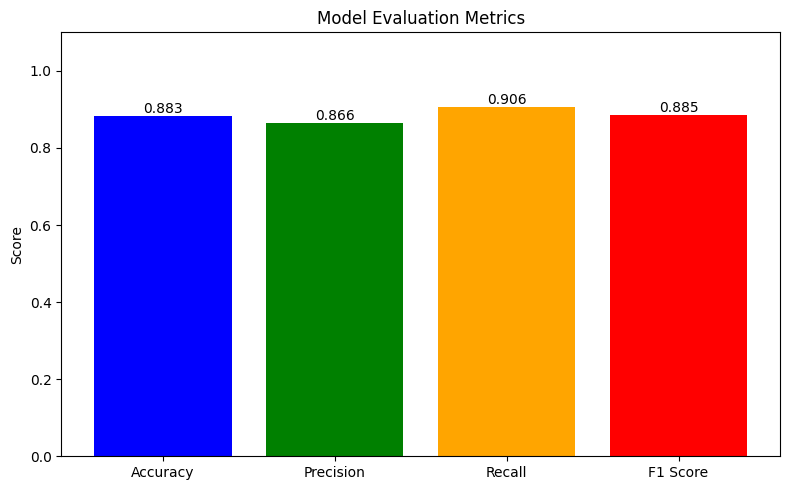

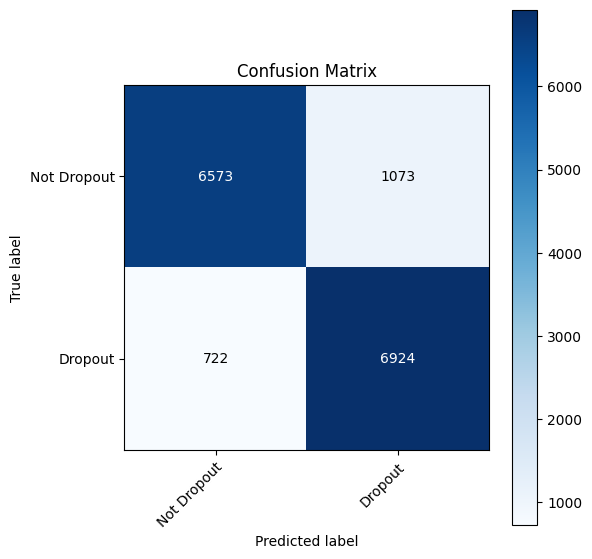


Running SHAP analysis...


In [ ]:
# -*- coding: utf-8 -*-
"""
Enhanced Random Forest pipeline with SHAP, LIME, and visualizations.
- Loads dataset `model1_210_features.csv`
- Cleans and preprocesses data
- Adds correlation analysis
- Trains RandomForest with RandomizedSearchCV + SMOTE
- Includes SHAP and LIME explainability
- Visualizes accuracy, loss, SHAP, and LIME explanations
"""

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from matplotlib.colors import LinearSegmentedColormap

# -----------------------------
# Configuration
# -----------------------------
file_path = 'model1_210_features_spliting.csv'  # Adjust if needed
random_state = 42
test_size = 0.2

def safe_drop(df: pd.DataFrame, cols):
    """Drop columns if they exist; ignore if not present."""
    return df.drop(columns=[c for c in cols if c in df.columns], errors='ignore')

def plot_correlation_heatmap(corr_df: pd.DataFrame, title: str):
    """Plot a correlation heatmap using matplotlib only (no seaborn)."""
    plt.figure(figsize=(12, 10))
    plt.imshow(corr_df, interpolation='none', aspect='auto')
    plt.colorbar(label='Correlation')
    ticks = np.arange(len(corr_df.columns))
    plt.xticks(ticks, corr_df.columns, rotation=90)
    plt.yticks(ticks, corr_df.index)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_top_corr_bar(corr_series: pd.Series, top_n: int = 20):
    """Bar chart for top-N correlations with dropout (absolute value sorting)."""
    top_features = corr_series.drop(labels=['dropout'], errors='ignore')
    top_features = top_features.reindex(top_features.abs().sort_values(ascending=False).head(top_n).index)
    plt.figure(figsize=(8, 6))
    plt.barh(top_features.index, top_features.values)
    plt.xlabel('Correlation with dropout')
    plt.ylabel('Feature')
    plt.title(f'Top {min(top_n, len(top_features))} Features Correlated with Dropout')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    """Plot a confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=['Not Dropout', 'Dropout'],
           yticklabels=['Not Dropout', 'Dropout'],
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()

def plot_metrics(y_test, y_pred):
    """Plot bar chart of evaluation metrics."""
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred)
    }

    plt.figure(figsize=(8, 5))
    bars = plt.bar(metrics.keys(), metrics.values(), color=['blue', 'green', 'orange', 'red'])
    plt.title('Model Evaluation Metrics')
    plt.ylabel('Score')
    plt.ylim(0, 1.1)

    # Add values on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

def main():
    # -----------------------------
    # Load data
    # -----------------------------
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Could not find '{file_path}'. Put the CSV next to this script or update file_path.")

    data = pd.read_csv(file_path)

    # Drop non-feature text IDs if present
    data = safe_drop(data, ['username', 'course_id', 'enrollment_id'])

    # Basic NA handling (adjust as needed)
    data = data.fillna(0)

    # Ensure `dropout` exists
    if 'dropout' not in data.columns:
        raise KeyError("Column 'dropout' not found in the dataset. Please ensure it exists in the CSV.")

    # -----------------------------
    # Correlation analysis (BEFORE scaling/SMOTE)
    # -----------------------------
    numeric_df = data.select_dtypes(include=[np.number])
    corr_full = numeric_df.corr()

    if 'dropout' in corr_full.columns:
        corr_with_dropout = corr_full['dropout'].sort_values(ascending=False)
        print("\n=== Correlation of each feature with 'dropout' (descending) ===")
        print(corr_with_dropout.to_string())

        # Plot bar of top correlated with dropout (excluding the target itself)
        plot_top_corr_bar(corr_with_dropout, top_n=20)

        # Heatmap on top-30 absolute correlations (including 'dropout')
        top_cols = corr_with_dropout.abs().sort_values(ascending=False).head(31).index.tolist()
        sub_corr = corr_full.loc[top_cols, top_cols]
        plot_correlation_heatmap(sub_corr, title="Correlation Heatmap (Top 30 by |corr with dropout|)")
    else:
        print("Warning: 'dropout' not in correlation matrix (check that it's numeric 0/1). Skipping correlation plots.")

    # -----------------------------
    # Train/test split and modeling
    # -----------------------------
    X = data.drop(columns=['dropout'])
    y = data['dropout']
    feature_names = X.columns.tolist()

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Handle class imbalance with SMOTE
    smote = SMOTE(sampling_strategy='auto', random_state=random_state)
    X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

    X_train, X_test, y_train, y_test = train_test_split(
        X_resampled, y_resampled, test_size=test_size, random_state=random_state, stratify=y_resampled
    )

    # RandomizedSearchCV for Random Forest
    param_dist_rf = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }
    rf = RandomForestClassifier(random_state=random_state, n_jobs=-1)
    rf_random_search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_dist_rf,
        n_iter=100,
        cv=3,
        random_state=random_state,
        n_jobs=-1,
        verbose=1
    )
    rf_random_search.fit(X_train, y_train)

    best_rf = rf_random_search.best_estimator_
    print("\nBest RandomForest Params:", rf_random_search.best_params_)

    y_pred = best_rf.predict(X_test)

    print("\n=== Test Metrics ===")
    print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred, zero_division=0):.4f}")
    print(f"Recall   : {recall_score(y_test, y_pred, zero_division=0):.4f}")
    print(f"F1 Score : {f1_score(y_test, y_pred, zero_division=0):.4f}")
    print("-" * 50)

    # -----------------------------
    # Visualization: Metrics and Confusion Matrix
    # -----------------------------
    plot_metrics(y_test, y_pred)
    plot_confusion_matrix(y_test, y_pred)

    # -----------------------------
    # SHAP Analysis
    # -----------------------------
    print("\nRunning SHAP analysis...")
    try:
        # Create SHAP explainer
        explainer = shap.TreeExplainer(best_rf)

        # Calculate SHAP values
        shap_values = explainer.shap_values(X_test)

        # Summary plot
        plt.figure()
        shap.summary_plot(shap_values[1], X_test, feature_names=feature_names, show=False)
        plt.title("SHAP Summary Plot")
        plt.tight_layout()
        plt.show()

        # Force plot for first observation
        plt.figure()
        shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_test[0,:],
                        feature_names=feature_names, matplotlib=True, show=False)
        plt.title("SHAP Force Plot for First Observation")
        plt.tight_layout()
        plt.show()

        # Dependence plot for top feature
        top_feature = np.abs(shap_values[1]).mean(0).argmax()
        plt.figure()
        shap.dependence_plot(top_feature, shap_values[1], X_test,
                            feature_names=feature_names, show=False)
        plt.title(f"SHAP Dependence Plot for {feature_names[top_feature]}")
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"SHAP visualization failed: {str(e)}")

    # -----------------------------
    # LIME Analysis
    # -----------------------------
    print("\nRunning LIME analysis...")
    try:
        # Create LIME explainer
        explainer = lime.lime_tabular.LimeTabularExplainer(
            X_train,
            feature_names=feature_names,
            class_names=['Not Dropout', 'Dropout'],
            mode='classification',
            random_state=random_state
        )

        # Explain a random instance
        idx = np.random.randint(0, X_test.shape[0])
        exp = explainer.explain_instance(
            X_test[idx],
            best_rf.predict_proba,
            num_features=10,
            top_labels=1
        )

        # Plot LIME explanation
        plt.figure()
        exp.as_pyplot_figure()
        plt.title(f"LIME Explanation for Observation {idx}")
        plt.tight_layout()
        plt.show()

        # Save explanation to HTML (optional)
        # exp.save_to_file('lime_explanation.html')

    except Exception as e:
        print(f"LIME visualization failed: {str(e)}")

if __name__ == '__main__':
    main()